## Kohinoor Chatterjee
## USC ID - 7961357311
## gitusername - kohinoor98

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# import os
# os.chdir('/content/drive/My Drive/data')


Mounted at /content/drive


In [46]:
import os
import cv2
import random
import math
import shutil
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB0
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

## Data generation by augmentation

In [4]:
data_dir = '/content/drive/My Drive/data'
output_dir = "/kaggle/working/processed_images"

## Train and Test data split for images

In [26]:
# Define the target size for the resized images
target_size = (224, 224)

# Define the train, validation, and test ratios
train_ratio = 0.7
val_ratio = 0.15

# Loop through each sport activity folder
image_dir = data_dir + "/Sport Images"
for sport in os.listdir(image_dir):
    if sport == "Image URLs":
        continue
    # Get the list of image file names in the current folder
    image_files = [item for item in os.listdir(os.path.join(image_dir, sport)) if ".gif" not in item]
    
    # Calculate the number of images to use for training, validation, and testing
    n_images = len(image_files)
    n_train = math.ceil(train_ratio * n_images)
    n_val = math.ceil(val_ratio * n_images)
    
    # Shuffle the list of image files
    random.shuffle(image_files)
    
    # Split the images into training, validation, and test sets
    train_files = image_files[:n_train]
    val_files = image_files[n_train:n_train+n_val]
    test_files = image_files[n_train+n_val:]
    
    # Create directories to store the split images
    os.makedirs(os.path.join(output_dir, "train", sport), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val", sport), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", sport), exist_ok=True)
    # Loop through the training images, resize them, and save them to the train folder
    for train_file in train_files:      
        img = cv2.imread(os.path.join(image_dir, sport, train_file))
        img = cv2.resize(img, target_size)
        cv2.imwrite(os.path.join(output_dir, "train", sport, train_file), img)

    # Loop through the validation images, resize them, and save them to the val folder
    for val_file in val_files:
        img = cv2.imread(os.path.join(image_dir, sport, val_file))
        img = cv2.resize(img, target_size)
        cv2.imwrite(os.path.join(output_dir, "val", sport, val_file), img)
    
    # Loop through the test images, resize them, and save them to the test folder
    for test_file in test_files:
        img = cv2.imread(os.path.join(image_dir, sport, test_file))
        img = cv2.resize(img, target_size)
        cv2.imwrite(os.path.join(output_dir, "test", sport, test_file), img)

# Define the range for randomly cropping the images
crop_range = (0.8, 1.0)

# Define the range for randomly zooming the images
zoom_range = (0.9, 1.1)

# Define the range for randomly rotating the images
rot_range = 30

# Define the range for randomly translating the images
trans_range = (0.1, 0.1)

contrast_range = (0.8, 1.2)

batch_size = 5


    
# Define the image data generator with augmentation options
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=zoom_range,
    rotation_range=rot_range,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=contrast_range,
    width_shift_range=trans_range[0],
    height_shift_range=trans_range[1],
    fill_mode='reflect'
)

# Load the image data into batches
train_data = datagen.flow_from_directory(
    directory=output_dir +'/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_data = datagen.flow_from_directory(
    directory=output_dir +'/val',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = datagen.flow_from_directory(
    directory=output_dir +'/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2815 images belonging to 5 classes.
Found 800 images belonging to 5 classes.
Found 819 images belonging to 5 classes.


In [ ]:
# data_path = '/content/drive/My Drive/data/Sport Images'
# train_data, val_data, test_data = load_data_and_split(data_path)

## Visualizing train and test data

## Preprocess data

## Create transfer learning models

In [27]:
def create_transfer_learning_model(base_model, num_classes, input_shape):
      for layer in base_model.layers:
          layer.trainable = False

      # Add new layers to the pre-trained model
      x = base_model.output
      pooling_layer = GlobalAveragePooling2D()(x)

      # Add a dense layer with 128 units and ReLU activation
      dense_layer = Dense(128, activation='relu')(pooling_layer)

      # Add a dropout layer to prevent overfitting
      dropout_layer = Dropout(0.5)(dense_layer)

      # Add a final dense layer with one unit and softmax activation for multi-class classification
      output_layer = Dense(5, activation='softmax')(dropout_layer)

      # Create the final model by combining the input layer and the output layer
      model = Model(inputs=base_model.input, outputs=output_layer)

      # Compile the model with Adam optimizer and SparseCategoricalCrossentropy loss
      model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
      
      return model


## Function to train and evaluate the models

In [42]:
class_indices = {'BaseballPitch': 0, 'Basketball': 1, 'Fencing': 2, 'TennisSwing': 3, 'VolleyballSpiking': 4}

def evaluate_model_images(model):
    # Evaluate on training set
    train_preds = model.predict(train_data)
    train_preds = np.argmax(train_preds, axis=1)
    train_labels = train_data.classes
    class_names = list(train_data.class_indices.keys())

    print("Image Training Results:")
    print(confusion_matrix(train_labels, train_preds))
    print(classification_report(train_labels, train_preds, target_names=class_names))

    # Evaluate on validation set
    test_preds = model.predict(test_data)
    test_preds = np.argmax(test_preds, axis=1)
    test_labels = test_data.classes

    print("Test Results:")
    print(confusion_matrix(test_labels, test_preds))
    print(classification_report(test_labels, test_preds, target_names=class_names))

def evaluate_model_video(model,test_data_path):
    # Load the test data
    test_data = generate_predictions_df(model, test_data_path)
    # Compute the confusion matrix
    true_labels = test_data['label']
    predicted_labels = test_data['prediction']
    classes = np.unique(true_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=classes)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

    # Compute the classification report
    class_report = classification_report(true_labels, predicted_labels, labels=classes, output_dict=True)

    # Compute the accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute the precision, recall, and F1-score
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Print the results
    print("Confusion Matrix:\n", conf_matrix_df)
    print("\nClassification Report:\n", pd.DataFrame(class_report).transpose())
    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)


In [29]:
def get_video_paths_and_labels(directory_path):
    video_paths = []
    labels = []
    for subdir, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.avi'):
                video_path = os.path.join(subdir, file)
                label = subdir.split('/')[-1]
                video_paths.append(video_path)
                labels.append(class_indices[label])
    df = pd.DataFrame({'video_path': video_paths, 'label': labels})
    return df

def predict_video(model, video_path):
    vidcap = cv2.VideoCapture(video_path)
    count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, count-1, 100).astype(int)
    frames = []
    for i in frame_indices:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = vidcap.read()
        frame = cv2.resize(frame, (224, 224))
        frames.append(frame)
    frames = np.array(frames)
    predictions = model.predict(frames,verbose=0)
    average_prediction = np.mean(predictions, axis=0)
    class_prediction = np.argmax(average_prediction)
    return class_prediction

def generate_predictions_df(model, directory_path):
    df = get_video_paths_and_labels(directory_path)
    predictions = []
    total_count = len(df['video_path'])
    for i, video_path in enumerate(df['video_path']):
        try:
            class_prediction = predict_video(model, video_path)
            predictions.append(class_prediction)
        except Exception as e:
#             print("Error while processing video: {}".format(video_path))
#             print(str(e))
            df = df[df['video_path'] != video_path]
        progress = i / total_count * 100
#         print("Progress: {:.2f}% ({}/{})".format(progress, i, total_count))
    df['prediction'] = predictions
    return df

## Train and evaluate ResNet50, EfficientNetB0, and VGG16 models

In [30]:
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_base.trainable = False
efficientnet_model = create_transfer_learning_model(efficientnet_base, "EfficientNetB0", (224, 224, 3))


In [31]:
def predict_video_frames(model, video_frames):
    predictions = model.predict(video_frames)
    return np.mean(predictions, axis=0)


In [32]:
# video_classes = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']
# def evaluate_on_videos(model, video_folder):
#     video_predictions = []
#     video_true_labels = []

#     for c_idx, c in enumerate(video_classes):
#         class_video_folder = os.path.join(video_folder, c)
#         for video_name in os.listdir(class_video_folder):
#             video_path = os.path.join(class_video_folder, video_name)
#             video_frames = extract_frames(video_path)
#             video_prediction = predict_video_frames(model, video_frames)
#             video_predictions.append(np.argmax(video_prediction))
#             video_true_labels.append(c_idx)

#     conf_matrix = confusion_matrix(video_true_labels, video_predictions)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(video_true_labels, video_predictions, average='weighted')
#     accuracy = accuracy_score(video_true_labels, video_predictions)

#     print("Confusion Matrix:")
#     print(conf_matrix)

#     print(f"Precision: {precision}")
#     print(f"Recall: {recall}")
#     print(f"Accuracy: {accuracy}")
#     print(f"F1 Score: {f1_score}")


In [33]:
def fit_model(model):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    # Train the model with the EarlyStopping callback
    history = model.fit(train_data, 
                        epochs=50,
                        validation_data=val_data,
                        callbacks=[early_stopping])
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/50
563/563 [==============================] - 55s 85ms/step - loss: 0.5228 - accuracy: 0.8135 - val_loss: 0.2212 - val_accuracy: 0.9237
Epoch 2/50
563/563 [==============================] - 46s 81ms/step - loss: 0.2877 - accuracy: 0.9044 - val_loss: 0.2057 - val_accuracy: 0.9287
Epoch 3/50
563/563 [==============================] - 46s 81ms/step - loss: 0.2581 - accuracy: 0.9083 - val_loss: 0.1669 - val_accuracy: 0.9463
Epoch 4/50
563/563 [==============================] - 46s 81ms/step - loss: 0.2201 - accuracy: 0.9240 - val_loss: 0.1525 - val_accuracy: 0.9438
Epoch 5/50
563/563 [==============================] - 46s 81ms/step - loss: 0.2010 - accuracy: 0.9325 - val_loss: 0.1338 - val_accuracy: 0.9475
Epoch 6/50
563/563 [==============================] - 45s 81ms/step - loss: 0.1879 - accuracy: 0.9307 - val_loss: 0.1502 - val_accuracy: 0.9438
Epoch 7/50
563/563 [==============================] - 46s 81ms/step - loss: 0.1846 - accuracy: 0.9350 - val_loss: 0.1375 - val_accuracy:

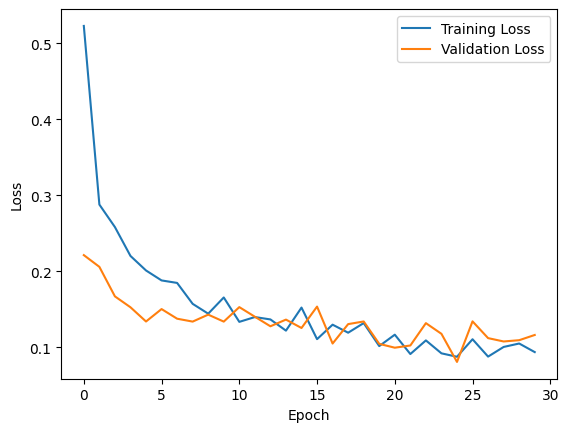

In [34]:
fit_model(efficientnet_model)

In [35]:
video_folder = '/content/drive/My Drive/data/Sport Videos'

# resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# resnet_base.trainable = False
# resnet_model = train_and_evaluate_model(resnet_base, "ResNet50", (256, 256, 3))

# efficientnet_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# efficientnet_base.trainable = False
# efficientnet_model = train_and_evaluate_model(efficientnet_base, "EfficientNetB0", (256, 256, 3))

# vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# vgg_base.trainable = False
# vgg_model = train_and_evaluate_model(vgg_base, "VGG16", (256, 256, 3))

# video_folder = '/content/drive/My Drive/data/Sport Videos'

# print("Evaluating ResNet50 Model")
# evaluate_on_videos(resnet_model, video_folder)



In [38]:
print("\nEvaluating EfficientNetB0 Model")
evaluate_model_images(efficientnet_model)



Evaluating EfficientNetB0 Model
563/563 [==============================] - 40s 68ms/step
Image Training Results:
[[666   1   1   0   0]
 [  0 441   0   0   5]
 [  0   1 554   0   0]
 [  4   0   2 494   0]
 [  0   4   7   0 635]]
              precision    recall  f1-score   support

    baseball       0.99      1.00      1.00       668
  basketball       0.99      0.99      0.99       446
     fencing       0.98      1.00      0.99       555
      tennis       1.00      0.99      0.99       500
  volleyball       0.99      0.98      0.99       646

    accuracy                           0.99      2815
   macro avg       0.99      0.99      0.99      2815
weighted avg       0.99      0.99      0.99      2815

164/164 [==============================] - 11s 65ms/step
Test Results:
[[204   0   1   0   0]
 [  0 136   1   0   5]
 [  1   1 166   0   2]
 [  1   0   5  95   5]
 [  0   2   2   0 192]]
              precision    recall  f1-score   support

    baseball       0.99      1.00      

In [47]:
evaluate_model_video(efficientnet_model,video_folder)

Confusion Matrix:
      0  1    2   3   4
0  120  0    9  15   0
1    0  0   71  25  32
2    0  0  109   1   1
3   34  0   36  87   6
4    0  0   68   1  44

Classification Report:
               precision    recall  f1-score     support
0              0.779221  0.833333  0.805369  144.000000
1              0.000000  0.000000  0.000000  128.000000
2              0.372014  0.981982  0.539604  111.000000
3              0.674419  0.533742  0.595890  163.000000
4              0.530120  0.389381  0.448980  113.000000
accuracy       0.546282  0.546282  0.546282    0.546282
macro avg      0.471155  0.547688  0.477969  659.000000
weighted avg   0.490645  0.546282  0.491250  659.000000

Accuracy: 0.5462822458270106
Precision: 0.49064515111096335
Recall: 0.5462822458270106
F1-score: 0.49125041704131855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif